In [1]:
import numpy as np
import gym
import tensorflow as tf
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv

learning_rate = 0.0005
epochs_number = 1000
batch_size = 256
replay_buffer_size = 256*4

env_name = 'MountainCar-v0'
environments_count = 24

# This code gets action and observation space sizes for 1D tasks
env = gym.make(env_name)
action_space = env.action_space.n if isinstance(env.action_space, gym.spaces.discrete.Discrete) else env.action_space.shape[0]
observation_space = env.observation_space.n if isinstance(env.observation_space, gym.spaces.discrete.Discrete) else env.observation_space.shape[0]


## Create environments vector

In [2]:
def make_env(env_id, seed):
    def _f():
        env = gym.make(env_id)
        env.seed(seed)
        
        # Desync environments
        env.reset()
        for i in range(int(env.spec.max_episode_steps*seed//environments_count)):
            env.step(env.action_space.sample())
        return env
    return _f

envs = [make_env(env_name, seed) for seed in range(environments_count)]
envs = DummyVecEnv(envs)

# observations = envs.reset()
# for t in range(100):
#     # print(envs.render(mode='human'))
#     actions = np.stack([envs.action_space.sample() for _ in range(nproc)])
#     observations, rewards, done, info = envs.step(actions)
    

## Create model architecture

In [3]:
tf.reset_default_graph()

state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])
l1 = tf.layers.dense(state_ph, units=128, activation=tf.nn.relu)
l2 = tf.layers.dense(l1, units=64, activation=tf.nn.relu)
output_linear = tf.layers.dense(l2, units=action_space)

output = tf.nn.softmax(output_linear)
action_op = tf.squeeze(tf.multinomial(logits=output_linear,num_samples=1), axis=1)
#action_op = tf.expand_dims(tf.constant(1), axis=0)

output_log = tf.nn.log_softmax(output_linear)

weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
action_ph = tf.placeholder(shape=[None], dtype=tf.int32)


action_one_hot = tf.one_hot(action_ph, action_space)
responsible_output_log = tf.reduce_sum(output_log * action_one_hot, axis=1)
loss = -tf.reduce_mean(responsible_output_log * weight_ph)

gradients = tf.gradients(loss, tf.trainable_variables())

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
update = optimizer.minimize(loss)

W0717 14:21:40.796464 19044 deprecation.py:323] From <ipython-input-3-f99a7ea034b7>:4: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0717 14:21:40.801454 19044 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0717 14:21:41.101745 19044 deprecation.py:323] From <ipython-input-3-f99a7ea034b7>:9: multinomial (from tensorflow.python.ops.random_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.random.categorical` instead.


In [4]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

# sess.run(loss, feed_dict={weight_ph: [0, 1, 2],
#                           action_ph: [1, 2, 3],
#                           state_ph: [[1,2], [1,2], [1,2]]})

In [5]:
def make_reward_to_go(reward):
    return np.cumsum(reward[::-1])[::-1]

make_reward_to_go(np.arange(1, 5))

array([10,  9,  7,  4], dtype=int32)

#TODO: подумать о последствиях слишком большого количества сэмплов в начале (решил рассинхронизацией)

In [14]:
def generate_batch(envs, batch_size, replay_buffer_size):
    envs_number = envs.num_envs
    observations = [[0 for i in range(observation_space)] for i in range(envs_number)]
    replay_buffer = np.empty((0,3), np.float32)
    
    # [state, action, weight] rollout lists for every environment instance
    rollouts = [np.empty((0, 3)) for i in range(envs_number)]

    while True:
        history = {'reward': []}
        replay_buffer = replay_buffer[batch_size:]
        
        # Main sampling cycle
        while len(replay_buffer) < replay_buffer_size:
            actions = sess.run(action_op, feed_dict={state_ph: observations})
            observations_old = observations
            observations, rewards, dones, _ = envs.step(actions)
            print(actions)
            
            time_point = np.array(list(zip(observations_old, actions, rewards)))
            for i in range(envs_number):
                rollouts[i] = np.append(rollouts[i], [time_point[i]], axis=0) # Regular python append
            
            if dones.any():
                if dones.all():
                    print('WARNING: envs are in sync!!')
                
                done_indexes = np.arange(envs_number)[dones]
                for i in done_indexes:
                    #print(dones, i, len(rollouts[i][:, 2]))
                    history['reward'].append(rollouts[i][:, 2].sum())

                    rollouts[i][:, 2] = make_reward_to_go(rollouts[i][:, 2])
                    replay_buffer = np.append(replay_buffer, rollouts[i], axis=0)
                    rollouts[i] = np.empty((0, 3))
                #history['reward'] = [np.mean(history['reward'])]
        
        np.random.shuffle(replay_buffer)
        replay_buffer = replay_buffer[:replay_buffer_size] ### QUESTIONABLE
        yield replay_buffer[:batch_size], history

a = generate_batch(envs, 8, 64)
# Makes them of equal lenght
for i in range(10):
    next(a)
next(a)[0]

[1 2 0 0 0 2 0 0 0 2 1 0 2 1 1 2 0 0 2 1 1 2 0 1]
[0 0 2 1 1 0 0 2 1 0 0 1 0 0 2 1 2 1 2 1 1 1 1 2]
[1 0 0 1 0 1 1 1 1 2 2 1 2 1 2 0 2 1 1 1 1 0 0 1]
[1 0 2 0 2 2 0 0 2 1 0 2 0 0 2 0 0 1 0 1 0 1 2 1]
[1 0 2 1 0 0 2 0 1 1 1 0 2 1 0 0 0 0 1 0 1 2 1 2]
[2 1 2 1 0 1 1 2 1 2 2 1 1 2 1 1 2 0 1 1 1 1 1 1]
[1 2 2 1 0 2 0 0 0 0 2 1 1 0 2 1 0 2 0 0 1 0 1 0]
[2 1 1 0 2 2 0 0 2 0 1 1 1 1 1 0 0 0 1 0 1 0 1 2]
[2 1 1 2 0 0 2 1 0 2 1 2 2 1 1 1 2 0 2 1 0 1 0 0]
[2 2 2 1 1 1 0 1 0 2 2 2 0 1 1 0 0 1 0 2 1 1 1 2]
[0 2 1 1 2 0 2 2 0 1 2 2 1 0 0 0 0 1 1 0 1 0 1 0]
[2 2 1 1 2 2 0 0 2 2 1 1 2 0 0 1 0 2 1 0 0 0 1 1]
[2 0 1 2 0 0 0 2 1 1 1 2 2 1 1 2 1 1 1 2 1 2 0 1]
[2 0 2 1 1 0 0 1 1 1 1 2 1 1 2 1 0 1 0 2 0 1 0 0]
[0 2 1 1 2 0 2 2 1 2 1 0 0 0 0 1 0 2 2 2 2 2 0 2]
[1 0 0 1 1 0 2 2 2 2 0 0 2 0 0 2 2 0 2 1 0 0 2 0]
[0 0 1 0 2 1 0 0 0 0 1 1 2 1 1 1 1 0 1 1 0 1 1 1]
[2 2 0 0 1 1 1 0 2 0 0 1 0 1 0 1 1 1 0 1 1 2 1 0]
[2 1 2 2 1 1 0 2 2 0 1 1 0 1 1 0 1 0 2 1 2 2 1 1]
[1 2 1 1 2 0 2 0 1 2 1 2 1 0 0 0 1 1 1 2 2 0 1 0]


array([[array([-0.5695624 ,  0.01276859], dtype=float32), 1, -82.0],
       [array([-0.3496966 ,  0.00973562], dtype=float32), 2, -64.0],
       [array([-0.4549635 ,  0.01250356], dtype=float32), 2, -74.0],
       [array([-0.5353892 ,  0.00688035], dtype=float32), 2, -84.0],
       [array([-0.5373753 ,  0.01040617], dtype=float32), 0, -43.0],
       [array([-0.4906482 , -0.00592239], dtype=float32), 1, -89.0],
       [array([-0.55511034, -0.00516182], dtype=float32), 1, -78.0],
       [array([-0.4419711 ,  0.01299243], dtype=float32), 0, -73.0]],
      dtype=object)

In [7]:
from tqdm import tqdm_notebook

history = {'reward': [], 'loss': [], 'gradients_max_abs': [], 'gradients_equal_zero': []}
batch_generator = generate_batch(envs,
                                 batch_size=batch_size,
                                 replay_buffer_size=replay_buffer_size)
# Makes them of equal lenght
for i in range(10):
    next(batch_generator)

for epoch in tqdm_notebook(range(epochs_number)):
    batch, batch_history = next(batch_generator)
    history['reward'] += batch_history['reward']
    
    _, loss_, gradients_ = sess.run([update, loss, gradients], feed_dict={state_ph: np.array(batch[:, 0].tolist()),
                                                    action_ph: batch[:, 1],
                                                    weight_ph: batch[:, 2]})
    
    history['gradients_max_abs'].append(np.max([np.max(np.abs(var_grad)) for var_grad in gradients_]))
    history['gradients_equal_zero'].append(np.sum([np.sum(var_grad == 0) for var_grad in gradients_]))
    
    history['loss'].append(loss_)


## Plot results

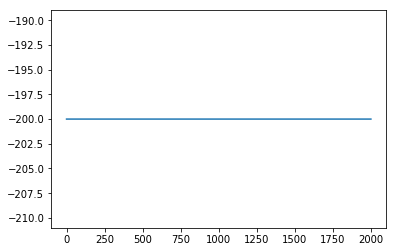

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving average
def smoothen_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(np.arange(len(history['reward'])), smoothen_curve(history['reward']))

## Loss doesn’t measure performance

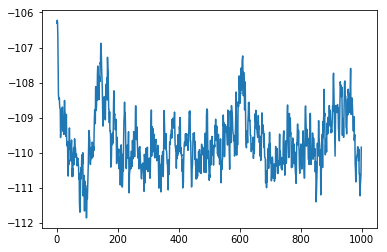

In [9]:
plt.plot(np.arange(len(history['loss'])), smoothen_curve(history['loss']))

## Gradients (not from adam)

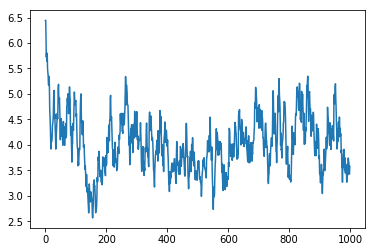

In [10]:
plt.plot(np.arange(len(history['gradients_max_abs'])), smoothen_curve(history['gradients_max_abs']))

In [11]:
# Gradients number
np.sum([np.ones_like(g).sum() for g in gradients_])

8835.0

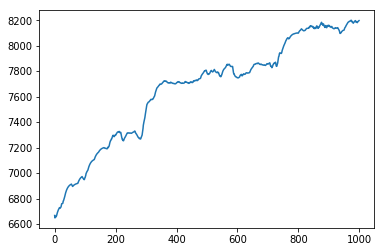

In [12]:
plt.plot(np.arange(len(history['gradients_equal_zero'])), smoothen_curve(history['gradients_equal_zero']))

## Our agent

In [13]:
observations = env.reset()

for i in range(10000):
    env.render()
    actions = sess.run(action_op, feed_dict={state_ph: [observations]})
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[0])
    
    if dones:
        observations = env.reset()
        print('Done')


Done
Done
Done
Done
Done
Done


KeyboardInterrupt: 

## Random agent

In [ ]:
observations = env.reset()

for i in range(1000):
    env.render()
    actions = [envs.action_space.sample() for i in range(envs.num_envs)]
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[0])
    
    if dones:
        observations = env.reset()
        print('Done')
    

In [ ]:
import time
saver = tf.train.Saver()
#save_path = saver.save(sess, f'./models/lunar-lander-long-{int(time.time())}.ckpt')
print("Model saved in path: %s" % save_path)

In [ ]:
# saver = tf.train.Saver()
# saver.restore(sess, "./models/lunar-lander-1563118687.ckpt")

In [19]:
a, b, c ,d = envs.step([0 for i in range(envs.num_envs)])
print(type(a))

<class 'numpy.ndarray'>


In [8]:
import numpy as np
a = np.array([np.arange(10),np.arange(10, 20),np.arange(20, 30)])
a

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

In [9]:
a.reshape(1, -1)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

In [5]:
np.arange(10)[::-1]

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])